In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

from keras.applications import ResNet152
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras import backend as K

from sklearn.svm import SVR
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from xgboost import XGBRegressor

import progressbar
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

## Generate Labels

In [8]:
f_train = open("lamem/splits/train_1.txt").readlines()
f_test = open("lamem/splits/test_1.txt").readlines()
f_val = open("lamem/splits/val_1.txt").readlines()

X_train_list = [x[:12] for x in f_train]
Y_train = np.array([float(x[13:21]) for x in f_train])

X_test_list = [x[:12] for x in f_test]
Y_test = np.array([float(x[13:21]) for x in f_test])

X_val_list = [x[:12] for x in f_val]
Y_val = np.array([float(x[13:21]) for x in f_val])

In [46]:
with h5py.File("Y.h5", "w") as h5f:
    for i in range(len(Y_train)):
        h5f.create_dataset(X_train_list[i], data=Y_train[i])
    for i in range(len(Y_test)):
        h5f.create_dataset(X_test_list[i], data=Y_test[i])
    for i in range(len(Y_val)):
        h5f.create_dataset(X_val_list[i], data=Y_val[i])

In [32]:
h5f = h5py.File("test_features.h5")

X_test_valide = [x in set(h5f.keys()) for x in X_test_list]
X_train_list = [x for x, y in zip(X_test_list, X_test_valide) if y]
Y_train = [x for x, y in zip(Y_test, X_test_valide) if y]

/Users/jojo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


## Load dataset

In [10]:
# with h5py.File("train_features.h5") as h5f:
#     X_train = np.array([h5f[img][:] for img in X_train_list])
# h5f_train = h5py.File("train_features.h5", "r")
# h5f_test = h5py.File("test_features.h5", "r")
# h5f_val = h5py.File("val_features.h5", "r")
# X  = np.array([h5f_train[img][:] for img in list(h5f_train.keys())] + [h5f_test[img][:] for img in list(h5f_test.keys())] + [h5f_val[img][:] for img in list(h5f_val.keys())])
# h5f2 = h5py.File("Y.h5", "r")
# Y  = np.array([h5f2[img].value for img in list(h5f_train.keys())+list(h5f_test.keys())+list(h5f_val.keys())])
X = np.load("X.npy")
Y = np.load("Y.npy")

In [11]:
print(X.shape, Y.shape)

(58741, 2048) (58741,)


In [14]:
train_set, test_set = train_test_split(range(len(X)), test_size=0.1)

## Prediction

### SVM

In [32]:
def my_custom_loss_func(y_true, y_pred):
    c, p = spearmanr(y_true, y_pred)
    return c
score = make_scorer(my_custom_loss_func, greater_is_better=True)

In [33]:
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import GridSearchCV

ALGORITHMS = {
        'model': SVR(gamma='scale'),
        'params': {
            "kernel": ['rbf', 'sigmoid'], # 'poly', 'sigmoid'
            "C": [0.1, 1.0, 10.0],
            "epsilon": [0.001, 1.0],
        }
    }

CV = 3
model = GridSearchCV(
        ALGORITHMS['model'],
        ALGORITHMS['params'],
        cv=CV,
        scoring=score,
        n_jobs=-1,
        )

In [37]:
model = LinearSVR(C=1.0, epsilon=0.1)

In [38]:
model.fit(X[train_set], Y[train_set])

/Users/jojo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.1, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

In [39]:
pred = model.predict(X[test_set])
c, p = spearmanr(Y[test_set], pred)

print("Spearmanr Result: correlation: {:.5f}, p-value: {}".format(c, p))

Spearmanr Result: correlation: 0.58618, p-value: 0.0


### Neural network

In [179]:
from keras.layers import *
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU
from keras.backend import expand_dims
from keras.losses import MeanSquaredLogarithmicError
import tensorflow as tf
from tensorflow.keras.losses import MSE

def correlation_loss(x, y):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return 2*MSE(x,y) - r_num / r_den

In [180]:
input_feature = Input(shape=(2048,), name='Input')
x = Dense(512, activation='relu')(input_feature)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [181]:
model = Model(input_feature, x)
model.compile(optimizer='adam', loss=correlation_loss)

In [182]:
model.fit(X[train_set], Y[train_set], batch_size=256, epochs=10, validation_data=(X[test_set], Y[test_set]))

Epoch 1/10
186/186 [==============================] - 2s 9ms/step - loss: -0.4153 - val_loss: -0.6119
Epoch 2/10
186/186 [==============================] - 2s 8ms/step - loss: -0.5868 - val_loss: -0.6335
Epoch 3/10
186/186 [==============================] - 2s 10ms/step - loss: -0.6162 - val_loss: -0.6373
Epoch 4/10
186/186 [==============================] - 2s 9ms/step - loss: -0.6346 - val_loss: -0.6415
Epoch 5/10
186/186 [==============================] - 2s 9ms/step - loss: -0.6473 - val_loss: -0.6485
Epoch 6/10
186/186 [==============================] - 2s 9ms/step - loss: -0.6549 - val_loss: -0.6472
Epoch 7/10
186/186 [==============================] - 2s 9ms/step - loss: -0.6641 - val_loss: -0.6484
Epoch 8/10
186/186 [==============================] - 2s 9ms/step - loss: -0.6694 - val_loss: -0.6498
Epoch 9/10
186/186 [==============================] - 2s 9ms/step - loss: -0.6806 - val_loss: -0.6524
Epoch 10/10
186/186 [==============================] - 2s 9ms/step - loss: -0.684

In [183]:
pred = model.predict(X[test_set])
c, p = spearmanr(Y[test_set], pred)

print("Spearmanr Result: correlation: {:.5f}, p-value: {}".format(c, p))

Spearmanr Result: correlation: 0.67365, p-value: 0.0


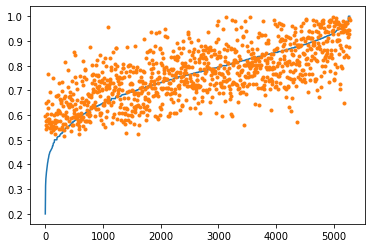

In [184]:
import matplotlib.pyplot as plt

c = list(range(0, len(Y[test_set]), 5))
index = np.argsort(Y[test_set])[c]
Y_pred = model.predict(X[test_set])

plt.plot(c, Y[test_set][index])
plt.plot(c, Y_pred[index], '.')

## Nomalized label

In [15]:
# Y_new = (Y-np.mean(Y))/np.std(Y)
Y_new = np.clip((Y-np.mean(Y))/np.std(Y), -1.0, 1.0)
# Y_new = (Y-np.min(Y))/(np.max(Y)-np.min(Y))

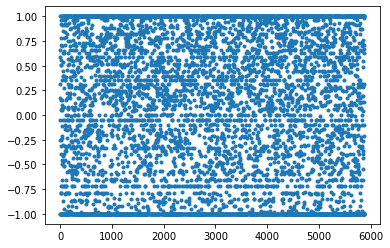

In [16]:
plt.plot(Y_new[test_set], ".")

In [255]:
def correlation_loss(x, y):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return 2*MSE(x,y) - r_num / r_den

In [256]:
activation = "tanh"

input_feature = Input(shape=(2048,), name='Input')
x = Dense(512, activation="relu")(input_feature)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(32, activation="relu")(x)
x = Dense(1, activation=activation)(x)

In [257]:
model = Model(input_feature, x)
model.compile(optimizer='adam', loss=correlation_loss)

In [258]:
model.fit(X[train_set], Y_new[train_set], batch_size=128, epochs=10, validation_data=(X[test_set], Y_new[test_set]))

Epoch 1/10
371/371 [==============================] - 3s 8ms/step - loss: 0.5696 - val_loss: 0.0580
Epoch 2/10
371/371 [==============================] - 3s 7ms/step - loss: 0.0851 - val_loss: -0.0093
Epoch 3/10
371/371 [==============================] - 3s 7ms/step - loss: 0.0182 - val_loss: -0.0130
Epoch 4/10
371/371 [==============================] - 3s 8ms/step - loss: -0.0214 - val_loss: -0.0275
Epoch 5/10
371/371 [==============================] - 3s 8ms/step - loss: -0.0417 - val_loss: -0.0506
Epoch 6/10
371/371 [==============================] - 3s 8ms/step - loss: -0.0674 - val_loss: -0.0540
Epoch 7/10
371/371 [==============================] - 3s 8ms/step - loss: -0.0768 - val_loss: -0.0269
Epoch 8/10
371/371 [==============================] - 3s 8ms/step - loss: -0.0898 - val_loss: -0.0555
Epoch 9/10
371/371 [==============================] - 3s 8ms/step - loss: -0.1041 - val_loss: -0.0305
Epoch 10/10
371/371 [==============================] - 3s 8ms/step - loss: -0.1231 - v

In [259]:
pred = model.predict(X[test_set])
c, p = spearmanr(Y_new[test_set], pred)

print("Spearmanr Result: correlation: {:.5f}, p-value: {}".format(c, p))

Spearmanr Result: correlation: 0.66343, p-value: 0.0


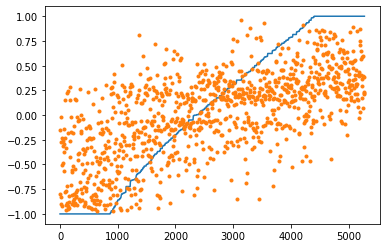

In [260]:
import matplotlib.pyplot as plt

c = list(range(0, len(Y_new[test_set]), 5))
index = np.argsort(Y_new[test_set])[c]
Y_new_pred = model.predict(X[test_set])
plt.plot(c, Y_new[test_set][index])
plt.plot(c, Y_new_pred[index], '.')

In [128]:
np.sum(Y_new[test_set]>1)

871

In [135]:
np.sum(Y_pred[Y[test_set]>0.5]>0.5) / np.sum(Y[test_set]>0.5)

0.9960560047327943

In [276]:
IMG_SIZE=(224, 224)
image = load_img("frame/dyson1.mp4-frame-200.jpg", target_size=IMG_SIZE)
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
features = ResNet152(weights="imagenet", include_top=False, pooling='avg').predict(image)

In [286]:
model.output

<tf.Tensor 'dense_112/Identity:0' shape=(None, 1) dtype=float32>

In [288]:
input_layer = model.get_layer("Input")
score_output = model.output

In [293]:
grads = K.gradients(score_output, input_layer.input)[0]

In [294]:
grads

<tf.Tensor 'gradients_5/dense_108/MatMul_grad/MatMul:0' shape=(None, 2048) dtype=float32>

## Visualization

In [273]:
model_res = ResNet152(weights="imagenet", include_top=False, pooling='avg')
input_layer = model_res.layers[0]
model_total = Model(model_res.input, model(model_res.output))

[INFO] Loading image frame/dyson1.mp4-frame-200.jpg...
[INFO] Image Name: dyson1
Predicted: [('n03494278', 'harmonica', 0.42593274), ('n03372029', 'flute', 0.2770136), ('n03642806', 'laptop', 0.04152207), ('n02978881', 'cassette', 0.038940996), ('n06359193', 'web_site', 0.03111298), ('n03110669', 'cornet', 0.02533463)]
Index: 593


In [ ]:
def get_image_activations(model, image_path, IMG_SIZE=(224, 224)):

    print('[INFO] Loading image {}...'.format(image_path))
    image_name = image_path.split(os.path.sep)[-1].split('.')[0]
    print('[INFO] Image Name: {}'.format(image_name))

    # load image
    image = load_img(image_path, target_size=IMG_SIZE)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = imagenet_utils.preprocess_input(image)

    # predict
    predictions = model.predict(image)
    print('Predicted:', predictions[0][0])

    # output of the model
    image_output = model.output[:]
    # output feature map of the block5_conv3 layer, the last convolutional layer in VGG16
    last_conv_layer = model.get_layer('conv5_block3_out')

    # Gradient of the class with regard to the output feature map of block5_conv3
    grads = K.gradients(image_output, last_conv_layer.output)[0]
    # Vector of shape (512,), where each entry is the mean intensity of the gradient over a specific feature-map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    # Lets you access the values of the quantities you just defined: pooled_grads and the output feature map of block5_conv3, given a sample image
    iterate = K.function(
        [ model.input ],
        [ pooled_grads, last_conv_layer.output[0] ])
    # Values of these two quantities, as Numpy arrays, given the sample image of two elephants
    pooled_grads_value, conv_layer_output_value = iterate([image])
    # Multiplies each channel in the feature-map array by 'how important this channel is' with regard to the 'elephant' class
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    # The channel-wise mean of the resulting feature map is the heatmap of the class activation.
    heatmap = np.mean(conv_layer_output_value, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    # plt.matshow(heatmap)
    if not os.path.exists('figures/activation_maps/'):
        os.makedirs('figures/activation_maps/')
    plt.imsave('figures/activation_maps/{}_heatmap.png'.format(image_name), heatmap)

    # Uses cv2 to load the original image
    img = cv2.imread(image_path)
    # Resizes the heatmap to be the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    # Converts the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    # Applies the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.4 + img
    # Saves the image
    cv2.imwrite('figures/activation_maps/{}_CAM.jpg'.format(image_name), superimposed_img)


In [ ]:
tf.compat.v1.experimental.output_all_intermediates(True)

get_image_activations(model_total, "lamem/images/" + X_test_list[0])